## Import Required Libraries

In [1]:
# common libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
import sklearn
import warnings
warnings.filterwarnings('ignore')

# machine learning libraries    

# preprocessing libraries, split data, gid search configuration, cross validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
# linear classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier   
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer

import pydotplus    
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import itertools

## Load Data

In [3]:
# read csv file
data = pd.read_csv('../data/final_merged_data.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

Shape of dataframe prior to modeling: (1269, 423)


,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,medication,weeks_attended,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates,gender
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,27,11,6,1.0,0.0,30.0,0.0,0.0,1.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,27,8,1,1.0,0.0,30.0,0.0,0.0,1.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,27,8,5,1.0,23.0,30.0,0.0,0.0,1.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,2.0,27,11,9,1.0,2.0,30.0,0.0,1.0,2.0
4,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3,11,6,1.0,0.0,4.0,0.0,26.0,2.0


## Review Tests

In [4]:
test_names = [
 #'Propoxyphene',
 #'Amphetamines',
 #'Cannabinoids',
 #'Benzodiazepines',
 #'MMethadone',
 #'Oxycodone',
 #'Cocaine',
 #'Methamphetamine',
 'Opiate300'
 ]

# define prefix parameter and call helper function to build the dataset
prefix = 'test_'
tests = helper.feature_selection(data, prefix, test_names)


Shape of tests DataFrame: (1269, 5)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
1264,1.0,1.0,1.0,1.0,1.0
1265,1.0,1.0,1.0,1.0,1.0
1266,1.0,1.0,1.0,1.0,1.0
1267,1.0,1.0,1.0,1.0,1.0


## Review Surveys


In [5]:
# comment out the drugs you don't want to include
survey_names = [
#'cannabis',
#'cocaine',
#'alcohol',
#'oxycodone',
#'mmethadone',
#'amphetamine',
#'methamphetamine',
'opiates',
#'benzodiazepines'
]

# call helper function to build  the dataset
prefix = 'survey_'
surveys = helper.feature_selection(data, prefix, survey_names)

Shape of tests DataFrame: (1269, 2)


,survey_opiates_0,survey_opiates_4
0,30.0,0.0
1,30.0,5.0
2,30.0,9.0
3,30.0,6.0
4,5.0,0.0
...,...,...
1264,30.0,0.0
1265,30.0,0.0
1266,20.0,0.0
1267,0.0,0.0


## Create Dataframe for Baseline Numeric Predictors

In [6]:
# medication data, included up to week 4
#group = 'meds'
#columns = 5
#dose = data[[col for col in data.columns if group in col]].iloc[:, :columns]

# medication data, binary
meds = data[['medication']]

# clinical opiate withdrawal scale -  included for assessment
cows = data[[col for col in data.columns if 'cows' in col]]

# rbs - risk behavior survey data
rbs = data[[col for col in data.columns if 'rbs' in col]]

# combine all the dataframes
num_df = pd.concat([tests, surveys, meds, cows, rbs], axis=1)
print('Shape of numeric dataframe after feature selection:', num_df.shape)
display(num_df)

Shape of numeric dataframe after feature selection: (1269, 15)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,medication,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,2.0,11,6,1.0,0.0,30.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,2.0,8,1,1.0,0.0,30.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,1.0,8,5,1.0,23.0,30.0,0.0,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,2.0,11,9,1.0,2.0,30.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,2.0,11,6,1.0,0.0,4.0,0.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,1.0,1.0,1.0,1.0,1.0,30.0,0.0,2.0,11,8,1.0,2.0,30.0,0.0,0.0
1265,1.0,1.0,1.0,1.0,1.0,30.0,0.0,2.0,26,10,1.0,13.0,30.0,0.0,4.0
1266,1.0,1.0,1.0,1.0,1.0,20.0,0.0,2.0,14,6,1.0,0.0,30.0,0.0,0.0
1267,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,12,5,0.0,0.0,0.0,0.0,0.0


## Review Categorical Data

In [7]:
# demographic features
dem = data[['gender']]

# mdh - mental health and medical history
#mdh = data[[col for col in data.columns if 'mdh' in col]]

# dsm diagnosis for addiction disorder
#dsm = data[[col for col in data.columns if 'dsm' in col]]

# physical exam data
#pex = data[[col for col in data.columns if 'pex' in col]]

# combine all the dataframes
cat_df = pd.concat([dem], axis=1) 

print('shape of the categorical df:', cat_df.shape)
display(cat_df)

shape of the categorical df: (1269, 1)


,gender
0,1.0
1,1.0
2,1.0
3,2.0
4,2.0
...,...
1264,2.0
1265,1.0
1266,2.0
1267,2.0


## Assign Target Variable and Merge

In [8]:
# assigne dropout variable
dropout = data['dropout']

# merge
new_data = pd.concat([num_df, cat_df, dropout], axis=1)

print('Shape of new datframe:',new_data.shape)
display(new_data)


Shape of new datframe: (1269, 17)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,medication,cows_predose,cows_postdose,rbs_sexual_activity,rbs_cocaine,rbs_heroine,rbs_amphetamines,rbs_other_opiates,gender,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,2.0,11,6,1.0,0.0,30.0,0.0,0.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,2.0,8,1,1.0,0.0,30.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,1.0,8,5,1.0,23.0,30.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,2.0,11,9,1.0,2.0,30.0,0.0,1.0,2.0,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,2.0,11,6,1.0,0.0,4.0,0.0,26.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,1.0,1.0,1.0,1.0,1.0,30.0,0.0,2.0,11,8,1.0,2.0,30.0,0.0,0.0,2.0,1.0
1265,1.0,1.0,1.0,1.0,1.0,30.0,0.0,2.0,26,10,1.0,13.0,30.0,0.0,4.0,1.0,1.0
1266,1.0,1.0,1.0,1.0,1.0,20.0,0.0,2.0,14,6,1.0,0.0,30.0,0.0,0.0,2.0,1.0
1267,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,12,5,0.0,0.0,0.0,0.0,0.0,2.0,1.0


## Split the Data to Dev and Test sets

In [9]:

# assign variables
X, y = new_data.drop(columns='dropout'), new_data['dropout']

# create the dev and test sets 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.14, random_state=42)

# create the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.16, random_state=42)

# check the shape of the train, validation, and test sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)



Shape of X_train: (916, 16)
Shape of X_val: (175, 16)
Shape of X_test: (178, 16)


## Review Patient Profile

In [10]:

X_train.iloc[21, :]

test_Opiate300_0        1.0
test_Opiate300_1        1.0
test_Opiate300_2        1.0
test_Opiate300_3        1.0
test_Opiate300_4        0.0
survey_opiates_0       30.0
survey_opiates_4       33.0
medication              1.0
cows_predose           22.0
cows_postdose          10.0
rbs_sexual_activity     1.0
rbs_cocaine             0.0
rbs_heroine            30.0
rbs_amphetamines        0.0
rbs_other_opiates       0.0
gender                  1.0
Name: 598, dtype: float64

## Fit A Decision Tree
No hyperparameter tuning

In [11]:
dt = DecisionTreeClassifier(max_depth=None, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Measure the Train and Test with C-Index

In [12]:
y_train_preds = dt.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {helper.cindex(y_val.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6355263157894737


## Update Hyperparams

In [13]:
# Update hyperparam configuration
dt_hyperparams = {
    'criterion': 'gini', 
    'max_depth': 3, 
    'max_features': None, 
    'min_samples_leaf': 1, 
    'min_samples_split': 2
    }

## Let's test the accuracy on a regularlized tree

In [14]:
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train, y_train)

y_train_preds = dt_reg.predict_proba(X_train)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val)[:, 1]
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {helper.cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.7851996469482126
Val C-Index (expected > 0.6): 0.7743421052631579


## See how the data fits the tree

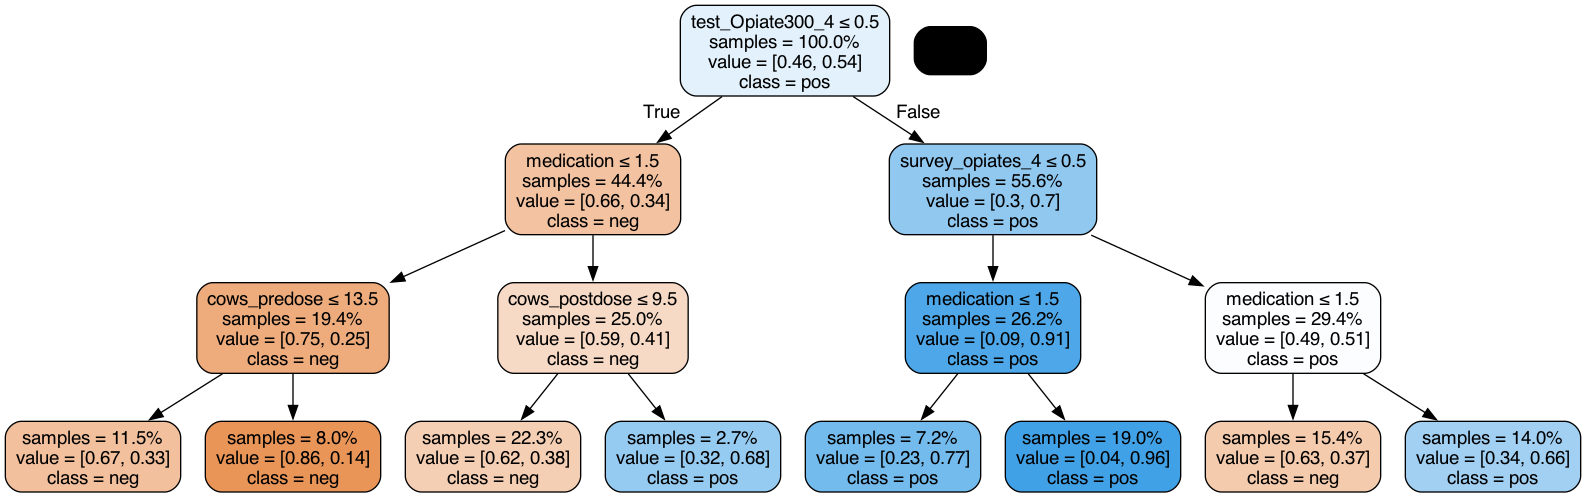

In [15]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train.columns, out_file=dot_data,  
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Save the new Data Model for ML Pipelines

In [17]:
# save data to csv
new_data.to_csv('../data/final_benchmark_model.csv', index=False)